In [11]:
import numpy as np
a = np.arange(15).reshape(3, 5)
print (a)
b = np.arange(15).reshape(3, 5)
print (np.multiply(a[[0,2,1,1,1],:],b[[1,2,0,0,0],:]))
print (np.sum(np.multiply(a[[0,2,1,1,1],:],b[[1,2,0,0,0],:]),axis=1))
print (a[[0,2,1,1,1,2],:].shape)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
[[  0   6  14  24  36]
 [100 121 144 169 196]
 [  0   6  14  24  36]
 [  0   6  14  24  36]
 [  0   6  14  24  36]]
[ 80 730  80  80  80]
(6, 5)


In [23]:
import theano
import numpy as np
import theano.tensor as T
ones = theano.shared(np.float32([[1,2,3],[4,5,6],[7,8,9]]))

#print(ones.get_value())
#result = T.dot(ones,ones)
result = T.mul(ones,ones)
print (result.eval())
result = T.sum(result,axis=1)
print(result.eval())

[[ 1.  4.  9.]
 [16. 25. 36.]
 [49. 64. 81.]]
[ 14.  77. 194.]


In [5]:
import pystan
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

la = fit.extract(permuted=True)  # return a dictionary of arrays
mu = la['mu']
## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)
print(fit)

W0727 04:01:33.990905 140054168667904 diagnostics.py:60] 1 of 2000 iterations ended with a divergence (0.05 %).
W0727 04:01:33.993163 140054168667904 diagnostics.py:81] Try running with adapt_delta larger than 0.8 to remove the divergences.


Inference for Stan model: anon_model_19a09b474d1901f191444eaf8a6b8ce2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         7.96    0.14   5.14  -2.27   4.78   7.97  11.25  18.18   1286    1.0
tau        6.61    0.17   5.47   0.34   2.45   5.38   9.14   20.8   1054    1.0
eta[1]     0.37    0.02   0.93   -1.5  -0.24    0.4   0.99   2.18   2267    1.0
eta[2]    -0.01    0.02   0.84   -1.7  -0.56  -0.02   0.53   1.66   2467    1.0
eta[3]    -0.22    0.02   0.93  -2.06  -0.84  -0.22    0.4   1.61   1766    1.0
eta[4]    -0.06    0.02   0.88  -1.74  -0.63  -0.08   0.51   1.68   2490    1.0
eta[5]    -0.37    0.02   0.85  -2.12  -0.95  -0.37    0.2   1.31   1610    1.0
eta[6]    -0.22    0.02    0.9  -1.94  -0.82  -0.24   0.37   1.55   2039    1.0
eta[7]     0.38    0.02    0.9  -1.35  -0.23   0.38   0.97   2.14   2102    1.0
eta[8]     0.

In [1]:
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import numpy as np
import edward as ed
import tensorflow as tf
import matplotlib.pyplot as plt
from edward.models import Normal

def build_toy_dataset(N, w):
    D = len(w)
    x = np.random.normal(0.0, 2.0, size=(N, D))
    y = np.dot(x, w) + np.random.normal(0.0, 0.05, size=N)
    return x, y

N = 10000  # size of training data
M = 128    # batch size during training
D = 10     # number of features

w_true = np.ones(D) * 5
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(235, w_true)

def generator(arrays, batch_size):
    """Generate batches, one with respect to each array's first axis."""
    starts = [0] * len(arrays)  # pointers to where we are in iteration
    while True:
        batches = []
        for i, array in enumerate(arrays):
            start = starts[i]
            stop = start + batch_size
            diff = stop - array.shape[0]
            if diff <= 0:
                batch = array[start:stop]
                starts[i] += batch_size
            else:
                batch = np.concatenate((array[start:], array[:diff]))
                starts[i] = diff
        batches.append(batch)
    yield batches

data = generator([X_train, y_train], M)

X = tf.placeholder(tf.float32, [None, D])
y_ph = tf.placeholder(tf.float32, [None])

w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=1.0)
qw = Normal(loc=tf.get_variable("qw/loc", [D]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [D])))
qb = Normal(loc=tf.get_variable("qb/loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))
n_batch = int(N / M)
n_epoch = 5

inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
inference.initialize( n_iter=n_batch * n_epoch, n_samples=5, scale={y: N / M})
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
    X_batch, y_batch = next(data)
    info_dict = inference.update({X: X_batch, y_ph: y_batch})
    inference.print_progress(info_dict)

W0727 03:48:16.508912 140054168667904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/edward/inferences/conjugacy/simplify.py:20: The name tf.log is deprecated. Please use tf.math.log instead.

W0727 03:48:16.510132 140054168667904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/edward/inferences/conjugacy/simplify.py:24: The name tf.reciprocal is deprecated. Please use tf.math.reciprocal instead.

W0727 03:48:16.808835 140054168667904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/edward/models/random_variable.py:112: Normal.__init__ (from tensorflow.python.ops.distributions.normal) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W0727 03:48:16.815080 140054168667904 deprecation.py:323

In [13]:
# coding=utf-8
import numpy as np
arr1 = np.arange(11,29)
print (arr1) #输出 [0 1 2 3 4 5 6 7 8 9]
arr2=arr1[[0,0,0,8,8,8,7,7,7]]
print (arr2+1) #输出 [1 1 5 6 ]
#arr2[0]=-1 #更改得到的新数组值不会影响原有数组
#print (arr1) #输出 [0 1 2 3 4 5 6 7 8 9]

[11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
[12 12 12 20 20 20 19 19 19]


In [4]:
print ((994169//1024)*1024)
print ((994169//1000)*1000)

993280
994000


In [1]:
import tensorflow as tf
import numpy as np

def add_layer(inputs, in_size, out_size, activation_function=None):
    Weights = tf.Variable(tf.random_normal([in_size, out_size]))
    biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)
    Wx_plus_b = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    return outputs

x_data = np.linspace(-1,1,300, dtype=np.float32)[:, np.newaxis]
noise = np.random.normal(0, 0.05, x_data.shape).astype(np.float32)
y_data = np.square(x_data) - 0.5 + noise

xs = tf.placeholder(tf.float32, [None, 1])
ys = tf.placeholder(tf.float32, [None, 1])

l1 = add_layer(xs, 1, 10, activation_function=tf.nn.relu)
prediction = add_layer(l1, 10, 1, activation_function=None)
loss = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction),reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

init = tf.global_variables_initializer() 
sess = tf.Session()
sess.run(init)
for i in range(1000):
    # training
    sess.run(train_step, feed_dict={xs: x_data, ys: y_data})
    if i % 50 == 0:
        # to see the step improvement
        print(sess.run(loss, feed_dict={xs: x_data, ys: y_data}))

1.4433997
0.007042788
0.0053495653
0.0048863823
0.0046660653
0.004541626
0.0044415817
0.004378759
0.004337095
0.004309917
0.0042841975
0.004253632
0.0042149876
0.0041711754
0.0041211215
0.004058876
0.0040026526
0.0039327946
0.0038429797
0.0037597588


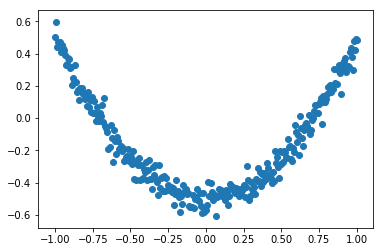

In [3]:
import matplotlib.pyplot as plt
# plot the real data
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x_data, y_data)
plt.ion()#本次运行请注释，全局运行不要注释
plt.show()

In [6]:
for i in range(1000):
    # training
    sess.run(train_step, feed_dict={xs: x_data, ys: y_data})
    if i % 50 == 0:
        # to visualize the result and improvement
        try:
            ax.lines.remove(lines[0])
        except Exception:
            pass
        prediction_value = sess.run(prediction, feed_dict={xs: x_data})
        # plot the prediction
        lines = ax.plot(x_data, prediction_value, 'r-', lw=5)
        plt.pause(0.1)
        plt.show()

In [2]:
import numpy as np
x1 = np.arange(6).reshape((3, 2))
print (x1)
x2 = np.arange(6).reshape((3, 2))
print (x2)
x3 = np.multiply(x1, x2)
print (x3)
x4 = np.sum(x3,axis=1)
print (x4)
print (x1[[0,2],:])

[[0 1]
 [2 3]
 [4 5]]
[[0 1]
 [2 3]
 [4 5]]
[[ 0  1]
 [ 4  9]
 [16 25]]
[ 1 13 41]
[[0 1]
 [4 5]]


In [5]:
import tensorflow as tf

#在 Tensorflow 中需要定义 placeholder 的 type ，一般为 float32 形式
input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)

# mul = multiply 是将input1和input2 做乘法运算，并输出为 output 
ouput = tf.multiply(input1, input2)
with tf.Session() as sess:
    print(sess.run(ouput, feed_dict={input1: [7.], input2: [2.]}))

[14.]


In [5]:
import tensorflow as tf
x = tf.placeholder(tf.float32, shape=(None, 2))
w1 = tf.Variable(tf.random_normal([2,3],stddev=1,seed=1))
w2 = tf.Variable(tf.random_normal([3,1],stddev=1,seed=1))

a = tf.matmul(x,w1)
y = tf.matmul(a,w2)

with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    print(sess.run(y, feed_dict={x:[[0.7,0.5],[0.2,0.3],[0.3,0.4],[0.4,0.5]]}))
    print(sess.run(w1))
    print(sess.run(w2))

Instructions for updating:
Colocations handled automatically by placer.
[[3.0904665]
 [1.2236414]
 [1.7270732]
 [2.2305048]]
[[-0.8113182   1.4845988   0.06532937]
 [-2.4427042   0.0992484   0.5912243 ]]
[[-0.8113182 ]
 [ 1.4845988 ]
 [ 0.06532937]]


In [3]:
import tensorflow as tf
import numpy as np

# create data
x_data = np.random.rand(100).astype(np.float32)
y_data = x_data*0.1 + 0.3
# create model
Weights = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
biases = tf.Variable(tf.zeros([1]))
y = Weights*x_data + biases
#loss function
loss = tf.reduce_mean(tf.square(y-y_data))
# optimizer
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)
#training
with tf.Session() as sess:
    sess.run( tf.global_variables_initializer())
    for step in range(100):
        sess.run(train)
        if step % 20 == 0:
            print(step, sess.run(Weights), sess.run(biases))

0 [-0.43409008] [0.8531586]
20 [-0.07629433] [0.39781126]
40 [0.05166814] [0.3268154]
60 [0.08674961] [0.30735156]
80 [0.09636736] [0.30201545]


In [4]:
import tensorflow as tf

state = tf.Variable(0, name='counter')
# 定义常量 one
one = tf.constant(1)
# 定义加法步骤 (注: 此步并没有直接计算)
new_value = tf.add(state, one)
# 将 State 更新成 new_value
update = tf.assign(state, new_value)
# 如果定义 Variable, 就一定要 initialize
init = tf.global_variables_initializer()  # 替换成这样就好
# 使用 Session
with tf.Session() as sess:
    sess.run(init)
    for _ in range(3):
        sess.run(update)
        print(sess.run(state))

1
2
3
